In [ ]:
!pip install BeautifulSoup4
from bs4 import BeautifulSoup
from xml.etree import ElementTree as et
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pickle
from collections import Counter
import multiprocessing as mp
import tqdm
from IPython import display
import time
import re
import cv2
!pip install MTCNN
from mtcnn.mtcnn import MTCNN
import gc

     |████████████████████████████████| 2.3MB 17.4MB/s 


In [ ]:
detector = MTCNN()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def make_preview(images, labels, n=25, len_per_image=2.6):
  sqrt_n = int(np.ceil(np.sqrt(n)))
  size = sqrt_n * len_per_image

  random_indices = np.random.choice(len(labels), size=n)

  plt.figure(figsize=(size, size))
  for i, idx in enumerate(random_indices):
      image = images[idx]
      label = labels[idx]
      
      plt.subplot(sqrt_n, sqrt_n, i+1)
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
  plt.show()

#Checking the number of individual classes in the photos with yolo annotations

In [ ]:
ann_paths = ['/content/drive/MyDrive/MaskDetection/Face Mask Detection/annotations',
             '/content/drive/MyDrive/MaskDetection/Medical Mask Dataset/Dataset/Medical_Masks_Dataset/xml_labels',
             '/content/drive/MyDrive/MaskDetection/Medical Mask Dataset/Dataset/Medical_Masks_Dataset/test_images/test_xml_labels']
img_paths = ['/content/drive/MyDrive/MaskDetection/Face Mask Detection/images',
             '/content/drive/MyDrive/MaskDetection/Medical Mask Dataset/Dataset/Medical_Masks_Dataset/images',
             '/content/drive/MyDrive/MaskDetection/Medical Mask Dataset/Dataset/Medical_Masks_Dataset/test_images']
labels_dict = {
  'bad' : 'without_mask', 
  'good' : 'with_mask', 
  'incorrect' : 'incorrect',
  'mask_weared_incorrect' : 'incorrect',
  'none' : 'incorrect', 
  'with_mask' : 'with_mask',
  'without_mask' : 'without_mask'}

In [ ]:
labels_counts = {'xml_path':[],
                 'img_path':[],
                 'xml_name':[],
                 'img_name':[],
                 'incorrect':[],
                 'with_mask':[],
                 'without_mask':[]
                  }

for ann_path, img_path in zip(ann_paths, img_paths):
  #list all xmls from directory
  xmls = os.listdir(ann_path)

  for i, xml in enumerate(xmls):
    if i % 100 == 0:
      print(i, 'from', len(xmls))
    
    xml_dict = {'incorrect':0,
                'with_mask':0,
                'without_mask':0}
    
    xml_path = os.path.join(ann_path, xml)
    labels_counts['xml_path'].append(xml_path)
    labels_counts['xml_name'].append(xml)

    tree = et.parse(xml_path)
    root = tree.getroot()

    #find image name
    img = root.find('filename').text
    single_img_path = os.path.join(img_path, img)
    labels_counts['img_path'].append(single_img_path)
    labels_counts['img_name'].append(img)
    
    #find labels
    objects = root.findall('object')
    for obj in objects:
      label = obj[0].text
      xml_dict[labels_dict[label]] += 1
    
    for label in xml_dict:
      labels_counts[label].append(xml_dict[label])

0 from 853
100 from 853
200 from 853
300 from 853
400 from 853
500 from 853
600 from 853
700 from 853
800 from 853
0 from 670
100 from 670
200 from 670
300 from 670
400 from 670
500 from 670
600 from 670
0 from 8


In [ ]:
df = pd.DataFrame.from_dict(labels_counts, orient='columns')

In [ ]:
df

xml_path  ... without_mask
0     /content/drive/MyDrive/MaskDetection/Face Mask...  ...            0
1     /content/drive/MyDrive/MaskDetection/Face Mask...  ...           17
2     /content/drive/MyDrive/MaskDetection/Face Mask...  ...            1
3     /content/drive/MyDrive/MaskDetection/Face Mask...  ...            0
4     /content/drive/MyDrive/MaskDetection/Face Mask...  ...            0
...                                                 ...  ...          ...
1526  /content/drive/MyDrive/MaskDetection/Medical M...  ...            1
1527  /content/drive/MyDrive/MaskDetection/Medical M...  ...            0
1528  /content/drive/MyDrive/MaskDetection/Medical M...  ...            0
1529  /content/drive/MyDrive/MaskDetection/Medical M...  ...            2
1530  /content/drive/MyDrive/MaskDetection/Medical M...  ...            0

[1531 rows x 7 columns]

In [ ]:
df.to_csv('/content/drive/MyDrive/MaskDetection/labels_counts.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MaskDetection/labels_counts.csv')

In [ ]:
df

xml_path  ... without_mask
0     /content/drive/MyDrive/MaskDetection/Face Mask...  ...            0
1     /content/drive/MyDrive/MaskDetection/Face Mask...  ...           17
2     /content/drive/MyDrive/MaskDetection/Face Mask...  ...            1
3     /content/drive/MyDrive/MaskDetection/Face Mask...  ...            0
4     /content/drive/MyDrive/MaskDetection/Face Mask...  ...            0
...                                                 ...  ...          ...
1526  /content/drive/MyDrive/MaskDetection/Medical M...  ...            1
1527  /content/drive/MyDrive/MaskDetection/Medical M...  ...            0
1528  /content/drive/MyDrive/MaskDetection/Medical M...  ...            0
1529  /content/drive/MyDrive/MaskDetection/Medical M...  ...            2
1530  /content/drive/MyDrive/MaskDetection/Medical M...  ...            0

[1531 rows x 7 columns]

In [ ]:
classes = ['incorrect', 'with_mask', 'without_mask']
for c in classes:
  mask = df[c] > 0
  print('Number of photos with', c, 'class:', len(df.loc[mask]))
  print('Number of examples of incorrect class:', df[c].sum(),'\n')

Number of photos with incorrect class: 197
Number of examples of incorrect class: 249 

Number of photos with with_mask class: 1409
Number of examples of incorrect class: 6353 

Number of photos with without_mask class: 523
Number of examples of incorrect class: 1384 



In [ ]:
for i in np.unique(df['incorrect']):
  print(i, '->', df.loc[df['incorrect']==i, 'incorrect'].value_counts().values[0])

0 -> 1334
1 -> 161
2 -> 24
3 -> 8
4 -> 4


In [ ]:
mask = df['incorrect'] > 0
print('Number of photos with incorrect class:', len(df.loc[mask]))

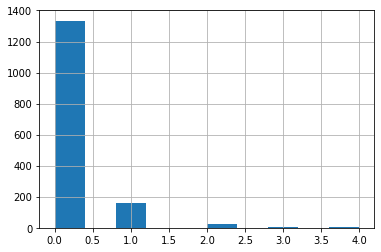

In [ ]:
df['incorrect'].hist()

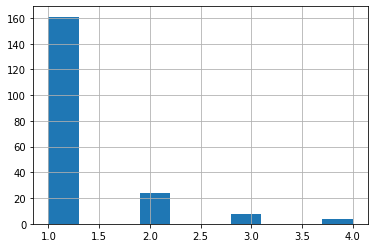

In [ ]:
df.loc[df['incorrect']>0, 'incorrect'].hist()

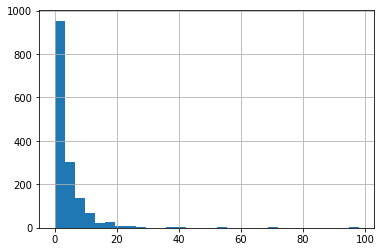

In [ ]:
df['with_mask'].hist(bins=30)

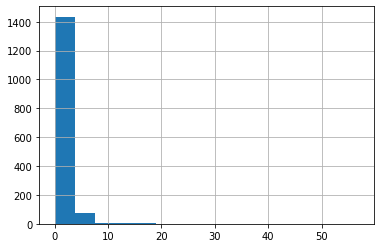

In [ ]:
df['without_mask'].hist(bins=15)

# Face Mask Detection and Medical Mask Dataset

In [ ]:
def read_from_xml(ann_path, img_path):

  labels = []
  images = []

  with open(ann_path, 'r') as file:
      ann = file.read()
      soup = BeautifulSoup(ann)

      image = Image.open(img_path)
      image = np.array(image)

      objects = soup.findAll('object')
      for obj in objects:
          label = obj.find('name').text
          labels.append(label)

          xmin = int(obj.find('xmin').text)
          ymin = int(obj.find('ymin').text)
          xmax = int(obj.find('xmax').text)
          ymax = int(obj.find('ymax').text)

          obj_image = image[ymin:ymax, xmin:xmax]
          images.append(obj_image)
    
  return images, labels

In [ ]:
all_images = []
all_labels = []
for i, row in df.iterrows():
  if i % 100 == 0:
    print(i, 'from', len(df))

  xml_path = row['xml_path']
  img_path = row['img_path']

  images, labels = read_from_xml(xml_path, img_path)

  start = len(all_labels)
  end = len(all_labels) + len(labels)
  df.loc[i, 'start'] = start
  df.loc[i, 'end'] = end

  all_images.extend(images)
  all_labels.extend(labels)

  if start > end:
    print('start > end')
    break

0 from 1531
100 from 1531
200 from 1531
300 from 1531
400 from 1531
500 from 1531
600 from 1531
700 from 1531
800 from 1531
900 from 1531
1000 from 1531
1100 from 1531
1200 from 1531
1300 from 1531
1400 from 1531
1500 from 1531


In [ ]:
df

xml_path  ...     end
0     /content/drive/MyDrive/MaskDetection/Face Mask...  ...     3.0
1     /content/drive/MyDrive/MaskDetection/Face Mask...  ...    29.0
2     /content/drive/MyDrive/MaskDetection/Face Mask...  ...    34.0
3     /content/drive/MyDrive/MaskDetection/Face Mask...  ...    43.0
4     /content/drive/MyDrive/MaskDetection/Face Mask...  ...    44.0
...                                                 ...  ...     ...
1526  /content/drive/MyDrive/MaskDetection/Medical M...  ...  7962.0
1527  /content/drive/MyDrive/MaskDetection/Medical M...  ...  7968.0
1528  /content/drive/MyDrive/MaskDetection/Medical M...  ...  7982.0
1529  /content/drive/MyDrive/MaskDetection/Medical M...  ...  7985.0
1530  /content/drive/MyDrive/MaskDetection/Medical M...  ...  7986.0

[1531 rows x 9 columns]

In [ ]:
df['start'] = df['start'].astype(int)
df['end'] = df['end'].astype(int)

In [ ]:
df.to_csv('/content/drive/MyDrive/MaskDetection/labels_counts_test.csv', index=False)

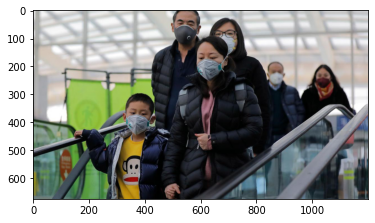

In [ ]:
img = Image.open(df.loc[1527,'img_path'])
plt.imshow(img)

In [ ]:
indices = list(range(df.loc[1527, 'start'], df.loc[1527,'end'],1))
indices

[7962, 7963, 7964, 7965, 7966, 7967]

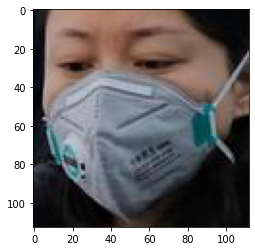

In [ ]:
plt.imshow(all_images[indices[2]])

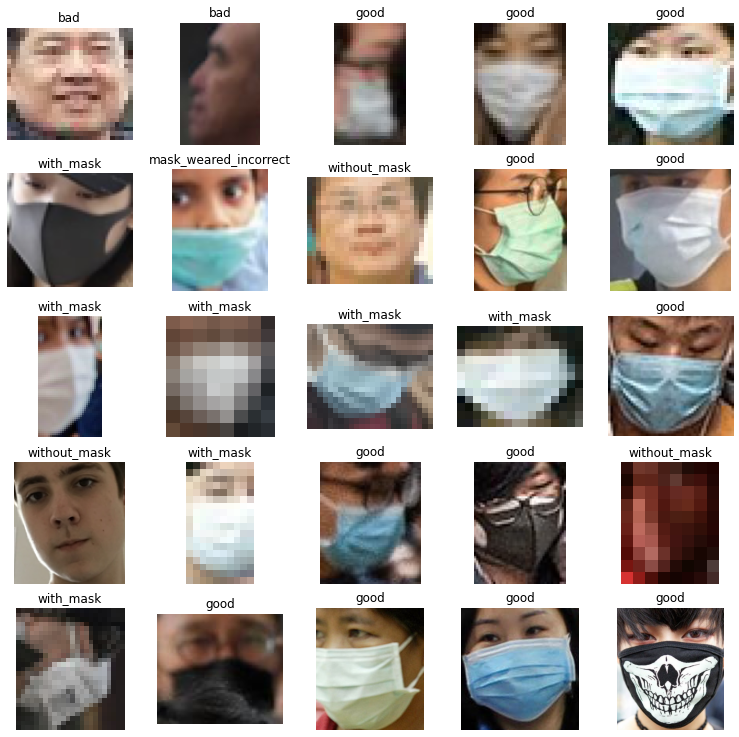

In [ ]:
make_preview(all_images, all_labels)

## Face mask detector(mask ,not mask, incorrect mask)

In [ ]:
detector_incorrect_path = '/content/drive/MyDrive/MaskDetection/Face mask detector(mask ,not mask, incorrect mask)/dataset/incorrect_mask'
detector_mask_path = '/content/drive/MyDrive/MaskDetection/Face mask detector(mask ,not mask, incorrect mask)/dataset/with_mask'
detector_no_mask_path = '/content/drive/MyDrive/MaskDetection/Face mask detector(mask ,not mask, incorrect mask)/dataset/without_mask'

paths = [detector_incorrect_path, detector_mask_path, detector_no_mask_path]
regex = ['incorrect.+', '[0-9]+-with.+', '^[0-9]+.+']
label = ['incorrect', 'with_mask', 'without_mask']

In [ ]:
def get_image(name):
  image_path = path + '/' + name
  image = Image.open(image_path)
  image = np.array(image)

  return image

In [ ]:
def get_original_data(path, regex, label):
    names = os.listdir(path)
    print('\nFound', len(names), 'images')
    regex = re.compile(regex)
    names = list(filter(regex.match, names))
    print('Selected', len(names), 'images\n')
    
    images = []

    pool = mp.Pool(mp.cpu_count())
    for image in tqdm.tqdm(pool.map(get_image, names), total=len(names)):
      display.clear_output(wait=True)
      images.append(image)    
    
    labels = [label for i in range(len(names))]
    
    return images, labels

In [ ]:
start = time.time()
f_detector_images = []
f_detector_labels = []
for path, reg, lab in zip(paths, regex, label):
    images, labels = get_original_data(path, reg, lab)
    f_detector_images += images
    f_detector_labels += labels

print('\n',time.time()-start)

100%|██████████| 408/408 [00:00<00:00, 668.04it/s]


 156.39565515518188


In [ ]:
len(f_detector_images)

917

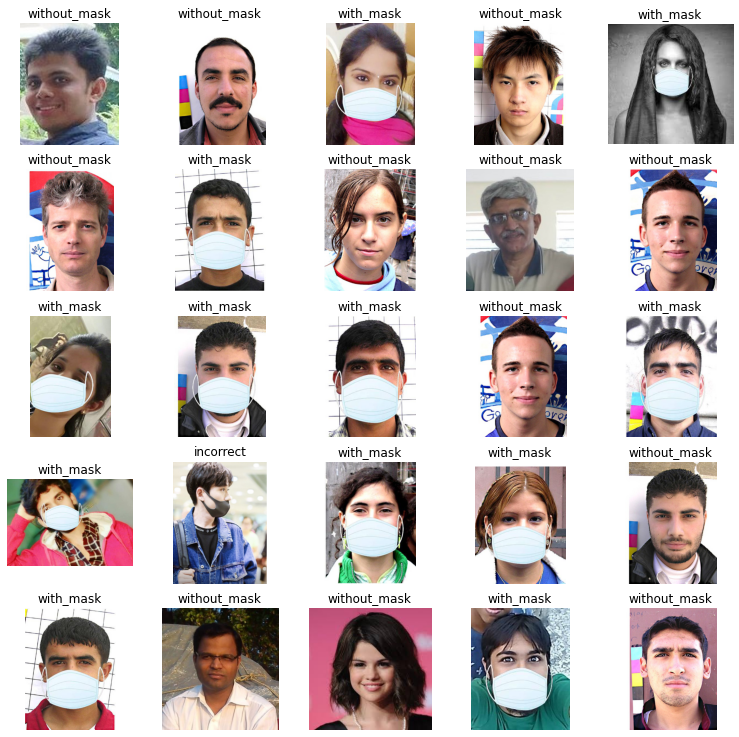

In [ ]:
make_preview(f_detector_images, f_detector_labels)

In [ ]:
len(all_images)

7986

In [ ]:
f_detector_indices = (len(all_images), len(all_images)+len(f_detector_images)-1)

In [ ]:
f_detector_indices

(7986, 8902)

In [ ]:
all_images += f_detector_images
all_labels += f_detector_labels

In [ ]:
len(all_images)

8903

## facemask

In [ ]:
facemask_path = '/content/drive/MyDrive/MaskDetection/facemask'

In [ ]:
def get_images_paths(input_path):
    images_paths = []
    if input_path[-1] != '/':
        input_path += '/'
    
    items = os.listdir(input_path)
    for item in items:
        next_path = input_path + item
        if not os.path.isdir(next_path):
            images_paths.append(next_path)
        else:
            images_paths.extend(get_images_paths(next_path))
    
    return images_paths

In [ ]:
def get_image(path):
  image = Image.open(path)
  image = np.array(image)
  images.append(image)
  
  label = path.split('/')[-2]
  labels.append(label)

  return image, label  

In [ ]:
paths = get_images_paths(facemask_path)

facemas_images = [] 
facemask_labels = []
pool = mp.Pool(mp.cpu_count())
for result in tqdm.tqdm(pool.map(get_image, paths), total=len(paths)):
  display.clear_output(wait=True)
  image = result[0]
  label = result[1]
  facemas_images.append(image)
  facemask_labels.append(label)

100%|██████████| 772/772 [00:01<00:00, 573.94it/s]


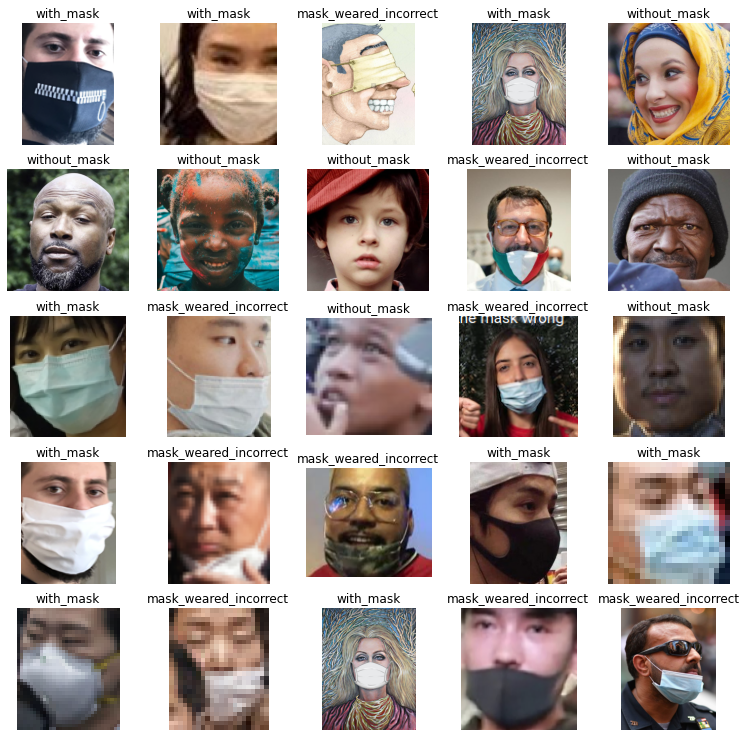

In [ ]:
make_preview(facemas_images, facemask_labels)

In [ ]:
len(all_images)

8903

In [ ]:
len(facemas_images)

772

In [ ]:
facemask_indices = (len(all_images), len(all_images)+len(facemas_images)-1)
facemask_indices

(8903, 9674)

In [ ]:
all_images += facemas_images
all_labels += facemask_labels

In [ ]:
len(all_images)

9675

In [ ]:
del f_detector_images
del f_detector_labels
del facemas_images
del facemask_labels

gc.collect()

59235

# Unification of labels

In [ ]:
np.unique(all_labels)

array(['bad', 'good', 'incorrect', 'mask_weared_incorrect', 'none',
       'with_mask', 'without_mask'], dtype='<U21')

In [ ]:
labels_dict = {
    'bad' : 'without_mask', 
    'good' : 'with_mask', 
    'incorrect' : 'incorrect',
    'mask_weared_incorrect' : 'incorrect',
    'none' : 'incorrect', 
    'with_mask' : 'with_mask',
    'without_mask' : 'without_mask'}

all_labels = [labels_dict[label] for label in all_labels]

In [ ]:
with open("/content/drive/MyDrive/MaskDetection/all_images.pk", 'wb') as file:
  pickle.dump({'all_images':all_images, 'all_labels':all_labels}, file)

# Resizing images to one size

In [ ]:
heights = [image.shape[0] for image in all_images]
widths = [image.shape[1] for image in all_images]
channels = [image.shape[2] for image in all_images if len(image.shape) == 3]

In [ ]:
Counter(heights).most_common()[:10]

[(428, 216),
 (18, 176),
 (19, 159),
 (20, 155),
 (22, 153),
 (23, 151),
 (600, 149),
 (17, 142),
 (24, 135),
 (21, 133)]

(array([8.736e+03, 8.030e+02, 6.300e+01, 3.500e+01, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 3.200e+01]),
 array([2.0000e+00, 3.4740e+02, 6.9280e+02, 1.0382e+03, 1.3836e+03,
        1.7290e+03, 2.0744e+03, 2.4198e+03, 2.7652e+03, 3.1106e+03,
        3.4560e+03]),
 <a list of 10 Patch objects>)

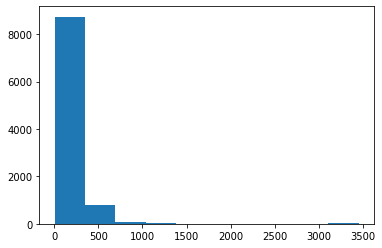

In [ ]:
plt.hist(heights)

In [ ]:
Counter(widths).most_common()[:10]

[(320, 272),
 (18, 179),
 (14, 177),
 (17, 169),
 (23, 156),
 (15, 154),
 (22, 148),
 (16, 148),
 (600, 147),
 (13, 146)]

(array([9.305e+03, 2.660e+02, 4.400e+01, 2.500e+01, 0.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.200e+01]),
 array([1.0000e+00, 4.6170e+02, 9.2240e+02, 1.3831e+03, 1.8438e+03,
        2.3045e+03, 2.7652e+03, 3.2259e+03, 3.6866e+03, 4.1473e+03,
        4.6080e+03]),
 <a list of 10 Patch objects>)

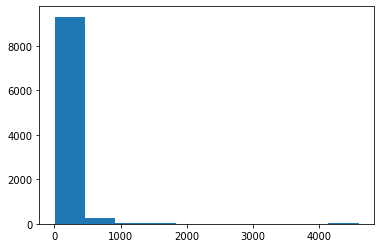

In [ ]:
plt.hist(widths)

In [ ]:
Counter(channels)

Counter({3: 5241, 4: 4433})

**For most networks from tf.keras.applications the image size cannot be smaller than 32 or 75, so images will be resized to 80x80.**

In [ ]:
def resize_image(image, new_shape=(224,224)):
  #delete 4-th channel
  if len(image.shape) == 3 and image.shape[-1] == 4:
    image = image[:,:,:-1]
  elif len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    print('to 3 channels')
  #resize
  image = Image.fromarray(image)
  image = image.resize(new_shape)
  image = np.array(image)
  return image

In [ ]:
resized_images = []
for i, image in enumerate(all_images):
  if i % 100 == 0:
    print(i, 'from', len(all_images))
  resized_image = resize_image(image)
  resized_images.append(resized_image)

0 from 9675
100 from 9675
200 from 9675
300 from 9675
400 from 9675
500 from 9675
600 from 9675
700 from 9675
800 from 9675
900 from 9675
1000 from 9675
1100 from 9675
1200 from 9675
1300 from 9675
1400 from 9675
1500 from 9675
1600 from 9675
1700 from 9675
1800 from 9675
1900 from 9675
2000 from 9675
2100 from 9675
2200 from 9675
2300 from 9675
2400 from 9675
2500 from 9675
2600 from 9675
2700 from 9675
2800 from 9675
2900 from 9675
3000 from 9675
3100 from 9675
3200 from 9675
3300 from 9675
3400 from 9675
3500 from 9675
3600 from 9675
3700 from 9675
3800 from 9675
3900 from 9675
4000 from 9675
4100 from 9675
4200 from 9675
4300 from 9675
4400 from 9675
4500 from 9675
4600 from 9675
4700 from 9675
4800 from 9675
4900 from 9675
5000 from 9675
5100 from 9675
5200 from 9675
to 3 channels
5300 from 9675
5400 from 9675
5500 from 9675
5600 from 9675
5700 from 9675
5800 from 9675
5900 from 9675
6000 from 9675
6100 from 9675
6200 from 9675
6300 from 9675
6400 from 9675
6500 from 9675
6600 fro

In [ ]:
del all_images
del all_labels
gc.collect()

140

# Find unique indices

In [ ]:
uniques = np.unique(np.array(resized_images), return_index=True, axis=0)

In [ ]:
unique_indices = uniques[1]
del uniques
gc.collect()
unique_indices

array([8865, 8370, 8899, ..., 8280, 8793, 8428])

In [ ]:
sorted_uniques = np.sort(unique_indices)

In [ ]:
np.save('/content/drive/MyDrive/MaskDetection/unique_indices.npy', sorted_uniques)

In [ ]:
del resized_images
del unique_indices
gc.collect()

219

# Drop duplicates

In [ ]:
with open('/content/drive/MyDrive/MaskDetection/all_images.pk', 'rb') as file:
  all = pickle.load(file)

In [ ]:
all_images = all['all_images']
all_labels = all['all_labels']

In [ ]:
del all
gc.collect()

228

In [ ]:
sorted_uniques = np.load('/content/drive/MyDrive/MaskDetection/unique_indices.npy')
sorted_uniques

array([   0,    1,    2, ..., 9672, 9673, 9674])

In [ ]:
print('Before:', len(all_images))

Before: 9675


In [ ]:
len(sorted_uniques)

9399

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MaskDetection/labels_counts_test.csv')

In [ ]:
df

xml_path  ... test
0     /content/drive/MyDrive/MaskDetection/Face Mask...  ...  NaN
1     /content/drive/MyDrive/MaskDetection/Face Mask...  ...  NaN
2     /content/drive/MyDrive/MaskDetection/Face Mask...  ...  NaN
3     /content/drive/MyDrive/MaskDetection/Face Mask...  ...  NaN
4     /content/drive/MyDrive/MaskDetection/Face Mask...  ...  NaN
...                                                 ...  ...  ...
1526  /content/drive/MyDrive/MaskDetection/Medical M...  ...  NaN
1527  /content/drive/MyDrive/MaskDetection/Medical M...  ...  NaN
1528  /content/drive/MyDrive/MaskDetection/Medical M...  ...  NaN
1529  /content/drive/MyDrive/MaskDetection/Medical M...  ...  NaN
1530  /content/drive/MyDrive/MaskDetection/Medical M...  ...  NaN

[1531 rows x 10 columns]

# Choose images for test set

In [ ]:
incorrect = df.loc[df['incorrect'] > 0]
n_incorrect = 0
for index, row in incorrect.iterrows():
  print('n_incorrect:', n_incorrect)
  if n_incorrect >= 200:
    break
  indices = list(range(row['start'], row['end'], 1))
  if all([idx in sorted_uniques for idx in indices]):
    df.loc[index, 'test'] = True
    n_incorrect += row['incorrect']
    to_drop = [np.where(sorted_uniques == idx)[0][0] for idx in indices]
    sorted_uniques = np.delete(sorted_uniques, to_drop)

n_incorrect: 0
n_incorrect: 1
n_incorrect: 2
n_incorrect: 3
n_incorrect: 4
n_incorrect: 5
n_incorrect: 6
n_incorrect: 7
n_incorrect: 8
n_incorrect: 10
n_incorrect: 11
n_incorrect: 14
n_incorrect: 15
n_incorrect: 16
n_incorrect: 17
n_incorrect: 18
n_incorrect: 19
n_incorrect: 20
n_incorrect: 21
n_incorrect: 22
n_incorrect: 24
n_incorrect: 25
n_incorrect: 27
n_incorrect: 28
n_incorrect: 29
n_incorrect: 30
n_incorrect: 31
n_incorrect: 32
n_incorrect: 36
n_incorrect: 37
n_incorrect: 38
n_incorrect: 39
n_incorrect: 40
n_incorrect: 41
n_incorrect: 42
n_incorrect: 43
n_incorrect: 44
n_incorrect: 45
n_incorrect: 46
n_incorrect: 49
n_incorrect: 51
n_incorrect: 52
n_incorrect: 53
n_incorrect: 54
n_incorrect: 55
n_incorrect: 56
n_incorrect: 57
n_incorrect: 59
n_incorrect: 60
n_incorrect: 61
n_incorrect: 62
n_incorrect: 63
n_incorrect: 64
n_incorrect: 65
n_incorrect: 66
n_incorrect: 68
n_incorrect: 69
n_incorrect: 70
n_incorrect: 71
n_incorrect: 75
n_incorrect: 76
n_incorrect: 77
n_incorrect: 78
n

In [ ]:
n_incorrect

200

In [ ]:
len(sorted_uniques)

7971

In [ ]:
df.loc[df['test']==True, 'incorrect'].sum()

200

In [ ]:
df.loc[df['test']==True, 'with_mask'].sum()

977

In [ ]:
df.loc[df['test']==True, 'without_mask'].sum()

251

In [ ]:
df.to_csv('/content/drive/MyDrive/MaskDetection/labels_counts_test.csv', index=False)

# Detect faces

In [ ]:
f_detector_indices = (7986, 8902)
facemask_indices = (8903, 9674)

In [ ]:
faces_indices = (7986, 9674)

In [ ]:
face_range = list(range(faces_indices[0], faces_indices[1], 1))

In [ ]:
def detect_face(image):
  h, w = image.shape[0], image.shape[1]
  #detect face
  detection = detector.detect_faces(image)
  if len(detection) > 0 and detection[0]['confidence'] > 0.5:
    #get detections
    x, y, width, height = detection[0]['box']
    start_x = x
    end_x = start_x + width
    start_y = y
    end_y = start_y + height

    (start_x, start_y) = (max(0, start_x), max(0, start_y))
    (end_x, end_y) = (min(w - 1, end_x), min(h - 1, end_y)) 
    #cut out face from image
    face = image[start_y:end_y, start_x:end_x]
  else:
    face = image
  face = np.array(face)
  return face

In [ ]:
for i, idx in enumerate(face_range):
  if i % 100 == 0:
    print(i, 'from', len(face_range))
  image = all_images[idx]
  if len(image.shape) == 3 and image.shape[-1] == 4:
    image = image[:,:,:3]
  elif len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    print('to 3 channels')
  face = detect_face(image)
  all_images[idx] = face

0 from 1688
100 from 1688
200 from 1688
300 from 1688
400 from 1688
500 from 1688
600 from 1688
700 from 1688
800 from 1688
900 from 1688
1000 from 1688
1100 from 1688
1200 from 1688
1300 from 1688
1400 from 1688
1500 from 1688
1600 from 1688


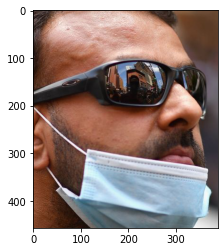

In [ ]:
plt.imshow(all_images[face_range[0]])

In [ ]:
def resize_image(image, new_shape=(224,224)):
  #delete 4-th channel
  if len(image.shape) == 3 and image.shape[-1] == 4:
    image = image[:,:,:-1]
  elif len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    print('to 3 channels')
  #resize
  image = Image.fromarray(image)
  image = image.resize(new_shape)
  image = np.array(image)
  return image

In [ ]:
for i in range(len(all_images)):
  if i % 100 == 0:
    print(i, 'from', len(all_images))
  image = all_images[i]
  resized_image = resize_image(image)
  all_images[i] = resized_image

0 from 9675
100 from 9675
200 from 9675
300 from 9675
400 from 9675
500 from 9675
600 from 9675
700 from 9675
800 from 9675
900 from 9675
1000 from 9675
1100 from 9675
1200 from 9675
1300 from 9675
1400 from 9675
1500 from 9675
1600 from 9675
1700 from 9675
1800 from 9675
1900 from 9675
2000 from 9675
2100 from 9675
2200 from 9675
2300 from 9675
2400 from 9675
2500 from 9675
2600 from 9675
2700 from 9675
2800 from 9675
2900 from 9675
3000 from 9675
3100 from 9675
3200 from 9675
3300 from 9675
3400 from 9675
3500 from 9675
3600 from 9675
3700 from 9675
3800 from 9675
3900 from 9675
4000 from 9675
4100 from 9675
4200 from 9675
4300 from 9675
4400 from 9675
4500 from 9675
4600 from 9675
4700 from 9675
4800 from 9675
4900 from 9675
5000 from 9675
5100 from 9675
5200 from 9675
to 3 channels
5300 from 9675
5400 from 9675
5500 from 9675
5600 from 9675
5700 from 9675
5800 from 9675
5900 from 9675
6000 from 9675
6100 from 9675
6200 from 9675
6300 from 9675
6400 from 9675
6500 from 9675
6600 fro

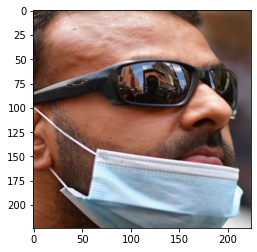

In [ ]:
plt.imshow(all_images[face_range[0]])

# Drop duplicates

In [ ]:
all_images = np.array(all_images)
all_labels = np.array(all_labels)

In [ ]:
all_images = all_images[sorted_uniques]
all_labels = all_labels[sorted_uniques]

In [ ]:
print('After:', len(all_images))

After: 7971


# Dataset preview

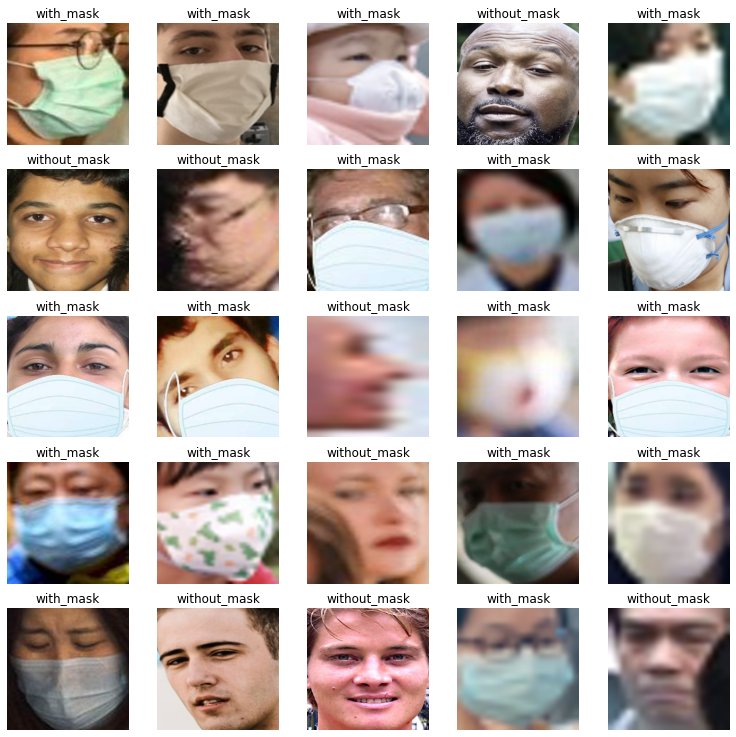

In [ ]:
n = 25

random_indices = np.random.choice(len(all_labels), size=n, replace=False)
plt.figure(figsize=(13,13))
for i, idx in enumerate(random_indices):
    image = all_images[idx]
    label = all_labels[idx]
    
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
plt.show()

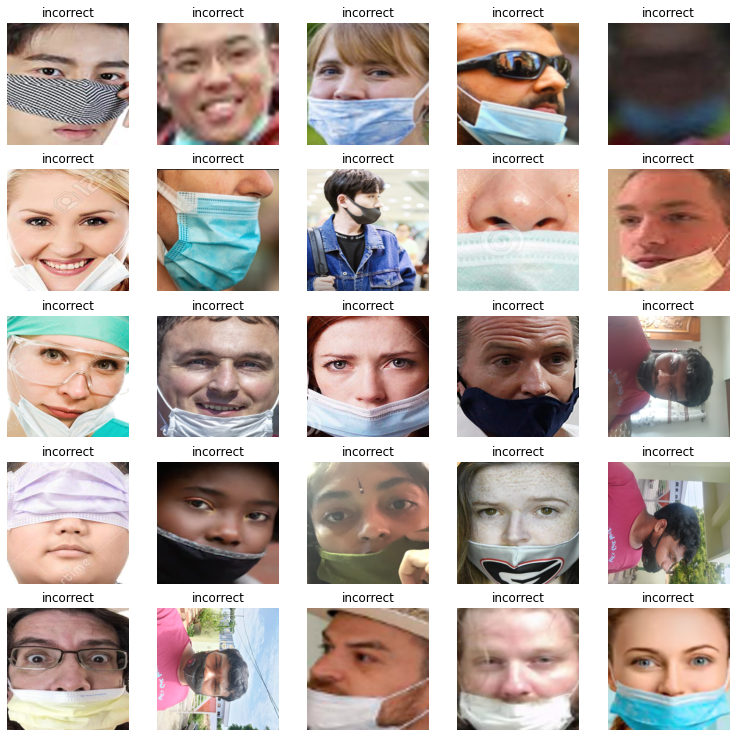

In [ ]:
n = 25
incorrect_indices = np.where(all_labels == 'incorrect')[0]
random_indices = np.random.choice(incorrect_indices, size=n, replace=False)
plt.figure(figsize=(13,13))
for i, idx in enumerate(random_indices):
    image = all_images[idx]
    label = all_labels[idx]
    
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
plt.show()

# Saving the dataset

In [ ]:
all_images.shape

(7971, 224, 224, 3)

In [ ]:
np.save('/content/drive/MyDrive/MaskDetection/real_images.npy', all_images)
np.save('/content/drive/MyDrive/MaskDetection/real_labels.npy', all_labels)

# Checking class sizes

In [ ]:
np.unique(all_labels, return_counts=True)

(array(['incorrect', 'with_mask', 'without_mask'], dtype='<U12'),
 array([ 320, 5918, 1733]))

# Test set

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MaskDetection/labels_counts_test.csv')
df.head()

xml_path  ... test
0  /content/drive/MyDrive/MaskDetection/Face Mask...  ...  NaN
1  /content/drive/MyDrive/MaskDetection/Face Mask...  ...  NaN
2  /content/drive/MyDrive/MaskDetection/Face Mask...  ...  NaN
3  /content/drive/MyDrive/MaskDetection/Face Mask...  ...  NaN
4  /content/drive/MyDrive/MaskDetection/Face Mask...  ...  NaN

[5 rows x 10 columns]

In [ ]:
test = df.loc[df['test']==True]
test.head()

xml_path  ...  test
14  /content/drive/MyDrive/MaskDetection/Face Mask...  ...  True
15  /content/drive/MyDrive/MaskDetection/Face Mask...  ...  True
27  /content/drive/MyDrive/MaskDetection/Face Mask...  ...  True
37  /content/drive/MyDrive/MaskDetection/Face Mask...  ...  True
57  /content/drive/MyDrive/MaskDetection/Face Mask...  ...  True

[5 rows x 10 columns]

In [ ]:
def read_from_xml(ann_path, img_path):

  labels = []
  images = []

  with open(ann_path, 'r') as file:
      ann = file.read()
      soup = BeautifulSoup(ann)

      image = Image.open(img_path)
      image = np.array(image)

      objects = soup.findAll('object')
      for obj in objects:
          label = obj.find('name').text
          labels.append(label)

          xmin = int(obj.find('xmin').text)
          ymin = int(obj.find('ymin').text)
          xmax = int(obj.find('xmax').text)
          ymax = int(obj.find('ymax').text)

          obj_image = image[ymin:ymax, xmin:xmax]
          images.append(obj_image)
    
  return images, labels

In [ ]:
labels_dict = {
    'bad' : 'without_mask', 
    'good' : 'with_mask', 
    'incorrect' : 'incorrect',
    'mask_weared_incorrect' : 'incorrect',
    'none' : 'incorrect', 
    'with_mask' : 'with_mask',
    'without_mask' : 'without_mask'}

In [ ]:
test_images = []
test_labels = []
test_incorrect = 0

valid_images = []
valid_labels = []
n = 0
t = True

test_indices = test.index.tolist()
np.random.shuffle(test_indices)

for i, idx in enumerate(test_indices):
  n += 1
  if n % 10 == 0:
    print(n, 'from', len(test))

  xml_path = test.loc[idx, 'xml_path']
  img_path = test.loc[idx, 'img_path']

  images, labels = read_from_xml(xml_path, img_path)
  labels = [labels_dict[label] for label in labels]


  if test_incorrect < 100 and t:
    t = False
    test_images.extend(images)
    test_labels.extend(labels)
    incorrect_n = row['incorrect']
    test_incorrect += incorrect_n
    test.loc[idx, 'test_or_val'] = 'test'

  else:
    t = True
    valid_images.extend(images)
    valid_labels.extend(labels)
    test.loc[idx, 'test_or_val'] = 'val'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


10 from 159
20 from 159
30 from 159
40 from 159
50 from 159
60 from 159
70 from 159
80 from 159
90 from 159
100 from 159
110 from 159
120 from 159
130 from 159
140 from 159
150 from 159


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/MaskDetection/test.csv')

In [ ]:
df.loc[df['test_or_val']=='test',:].count()

xml_path        80
img_path        80
xml_name        80
img_name        80
incorrect       80
with_mask       80
without_mask    80
start           80
end             80
test            80
test_or_val     80
dtype: int64

In [ ]:
len(test_images)

755

In [ ]:
np.unique(test_labels, return_counts=True)

(array(['incorrect', 'with_mask', 'without_mask'], dtype='<U12'),
 array([ 97, 525, 133]))

In [ ]:
len(valid_images)

673

In [ ]:
np.unique(valid_labels, return_counts=True)

(array(['incorrect', 'with_mask', 'without_mask'], dtype='<U12'),
 array([103, 452, 118]))

In [ ]:
def resize_image(image, new_shape=(224,224)):
  #delete 4-th channel
  if len(image.shape) == 3 and image.shape[-1] == 4:
    image = image[:,:,:-1]
  elif len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    print('to 3 channels')
  #resize
  image = Image.fromarray(image)
  image = image.resize(new_shape)
  image = np.array(image)
  return image

In [ ]:
resized_test_images = []
n = 0
for i, image in enumerate(test_images):
  n += 1
  if n % 10 == 0:
    print(n, 'from', len(test_images))
  resized_image = resize_image(image)
  resized_test_images.append(resized_image)

10 from 755
20 from 755
30 from 755
40 from 755
50 from 755
60 from 755
70 from 755
80 from 755
90 from 755
100 from 755
110 from 755
120 from 755
130 from 755
140 from 755
150 from 755
160 from 755
170 from 755
180 from 755
190 from 755
200 from 755
210 from 755
220 from 755
230 from 755
240 from 755
250 from 755
260 from 755
270 from 755
280 from 755
290 from 755
300 from 755
310 from 755
320 from 755
330 from 755
340 from 755
350 from 755
360 from 755
370 from 755
380 from 755
390 from 755
400 from 755
410 from 755
420 from 755
430 from 755
440 from 755
450 from 755
460 from 755
470 from 755
480 from 755
490 from 755
500 from 755
510 from 755
520 from 755
530 from 755
540 from 755
550 from 755
560 from 755
570 from 755
580 from 755
590 from 755
600 from 755
610 from 755
620 from 755
630 from 755
640 from 755
650 from 755
660 from 755
670 from 755
680 from 755
690 from 755
700 from 755
710 from 755
720 from 755
730 from 755
740 from 755
750 from 755


In [ ]:
resized_valid_images = []
n = 0
for i, image in enumerate(valid_images):
  n += 1
  if n % 10 == 0:
    print(n, 'from', len(valid_images))
  resized_image = resize_image(image)
  resized_valid_images.append(resized_image)

10 from 673
20 from 673
30 from 673
40 from 673
50 from 673
60 from 673
70 from 673
80 from 673
90 from 673
100 from 673
110 from 673
120 from 673
130 from 673
140 from 673
150 from 673
160 from 673
170 from 673
180 from 673
190 from 673
200 from 673
210 from 673
220 from 673
230 from 673
240 from 673
250 from 673
260 from 673
270 from 673
280 from 673
290 from 673
300 from 673
310 from 673
320 from 673
330 from 673
340 from 673
350 from 673
360 from 673
370 from 673
380 from 673
390 from 673
400 from 673
410 from 673
420 from 673
430 from 673
440 from 673
450 from 673
460 from 673
470 from 673
480 from 673
490 from 673
500 from 673
510 from 673
520 from 673
530 from 673
540 from 673
550 from 673
560 from 673
570 from 673
580 from 673
590 from 673
600 from 673
610 from 673
620 from 673
630 from 673
640 from 673
650 from 673
660 from 673
670 from 673


In [ ]:
test_images = np.array(resized_test_images)
test_labels = np.array(test_labels)

In [ ]:
valid_images = np.array(resized_valid_images)
valid_labels = np.array(valid_labels)

In [ ]:
np.unique(test_labels, return_counts=True)

(array(['incorrect', 'with_mask', 'without_mask'], dtype='<U12'),
 array([ 97, 525, 133]))

In [ ]:
np.unique(valid_labels, return_counts=True)

(array(['incorrect', 'with_mask', 'without_mask'], dtype='<U12'),
 array([103, 452, 118]))

In [ ]:
np.save('/content/drive/MyDrive/MaskDetection/x_test.npy', valid_images)
np.save('/content/drive/MyDrive/MaskDetection/y_test.npy', valid_labels)

np.save('/content/drive/MyDrive/MaskDetection/x_valid.npy', test_images)
np.save('/content/drive/MyDrive/MaskDetection/y_valid.npy', test_labels)

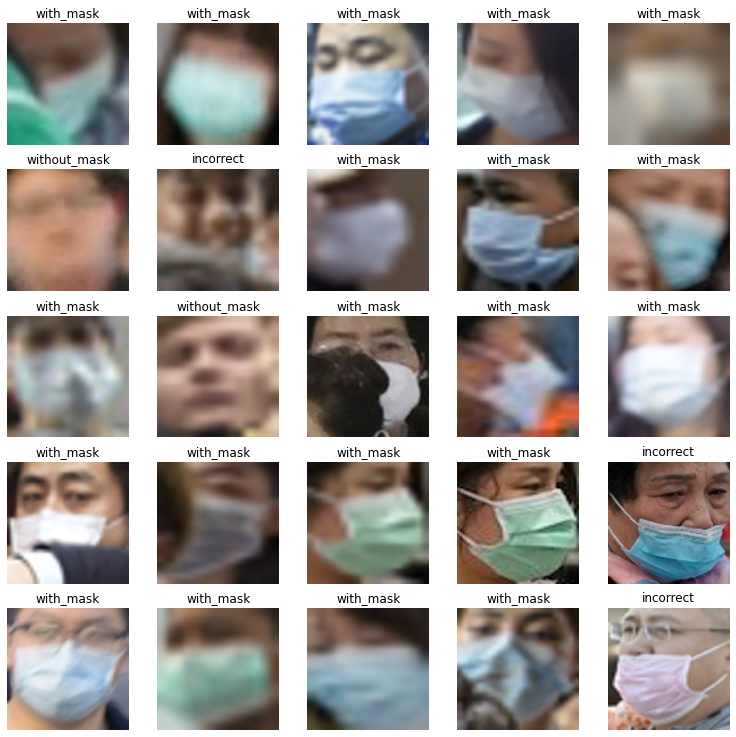

In [ ]:
n = 25

random_indices = np.random.choice(len(test_labels), size=n, replace=False)
plt.figure(figsize=(13,13))
for i, idx in enumerate(random_indices):
    image = test_images[idx]
    label = test_labels[idx]
    
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
plt.show()

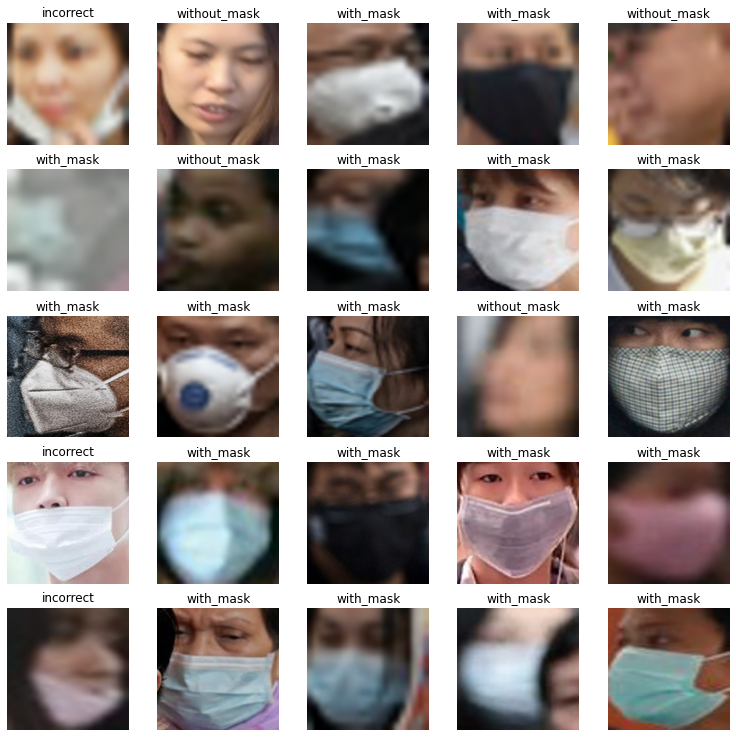

In [ ]:
make_preview(test_images, test_labels)

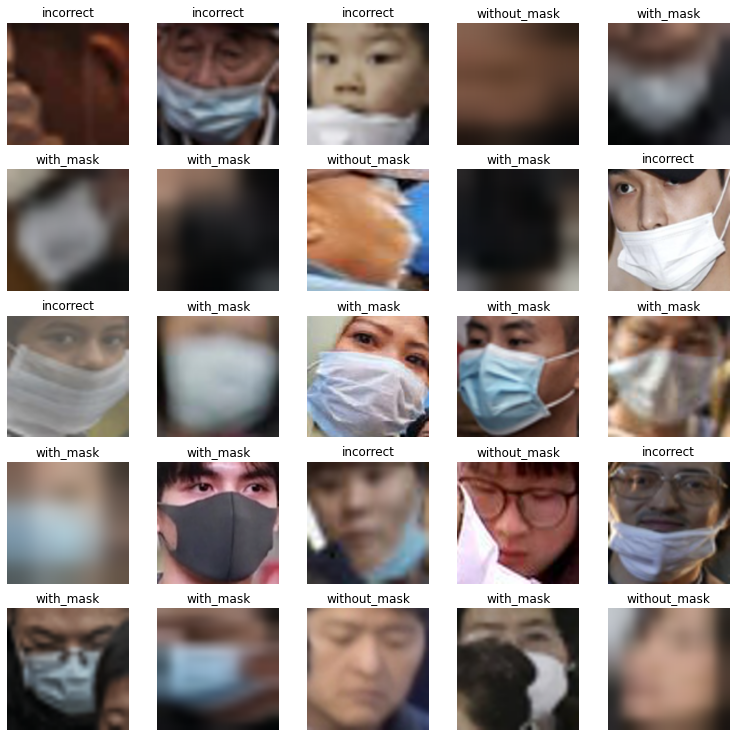

In [ ]:
make_preview(valid_images, valid_labels)

In [ ]:
test.loc[:690,'incorrect'].sum() + test.loc[:690,'with_mask'].sum() + test.loc[:690, 'without_mask'].sum() 

793

In [ ]:
test_images.shape

(793, 224, 224, 3)

In [ ]:
valid_images.shape

(635, 224, 224, 3)

# Utworzenie zbioru testowego

In [ ]:
import shutil
import pandas as pd
import os

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/MaskDetection/test.csv')
test.head()

xml_path  ... test_or_val
0  /content/drive/MyDrive/MaskDetection/Face Mask...  ...        test
1  /content/drive/MyDrive/MaskDetection/Face Mask...  ...         val
2  /content/drive/MyDrive/MaskDetection/Face Mask...  ...        test
3  /content/drive/MyDrive/MaskDetection/Face Mask...  ...        test
4  /content/drive/MyDrive/MaskDetection/Face Mask...  ...         val

[5 rows x 11 columns]

In [ ]:
test_set = test.loc[test['test_or_val']=='val', :]
test_set.head()

xml_path  ... test_or_val
1   /content/drive/MyDrive/MaskDetection/Face Mask...  ...         val
4   /content/drive/MyDrive/MaskDetection/Face Mask...  ...         val
5   /content/drive/MyDrive/MaskDetection/Face Mask...  ...         val
9   /content/drive/MyDrive/MaskDetection/Face Mask...  ...         val
10  /content/drive/MyDrive/MaskDetection/Face Mask...  ...         val

[5 rows x 11 columns]

In [ ]:
img_dest = '/content/drive/MyDrive/MaskDetection/Test set/images'
xml_dest = '/content/drive/MyDrive/MaskDetection/Test set/xmls'
for i, row in test_set.iterrows():
  print(i, 'from', len(test_set))

  img_path = row['img_path']
  img_name = row['img_name']

  xml_path = row['xml_path']
  xml_name = row['xml_name']

  dest_img_path = os.path.join(img_dest, img_name)
  dest_xml_path = os.path.join(xml_dest, xml_name)

  shutil.copyfile(img_path, dest_img_path)
  shutil.copyfile(xml_path, dest_xml_path)

1 from 79
4 from 79
5 from 79
9 from 79
10 from 79
19 from 79
20 from 79
21 from 79
23 from 79
26 from 79
28 from 79
30 from 79
31 from 79
35 from 79
39 from 79
40 from 79
44 from 79
46 from 79
47 from 79
48 from 79
49 from 79
50 from 79
53 from 79
54 from 79
55 from 79
56 from 79
57 from 79
58 from 79
59 from 79
62 from 79
63 from 79
64 from 79
65 from 79
66 from 79
69 from 79
71 from 79
72 from 79
74 from 79
76 from 79
78 from 79
79 from 79
80 from 79
81 from 79
82 from 79
85 from 79
86 from 79
88 from 79
89 from 79
90 from 79
91 from 79
92 from 79
93 from 79
94 from 79
95 from 79
97 from 79
99 from 79
110 from 79
111 from 79
112 from 79
113 from 79
114 from 79
116 from 79
118 from 79
120 from 79
127 from 79
128 from 79
130 from 79
131 from 79
134 from 79
136 from 79
137 from 79
138 from 79
140 from 79
143 from 79
147 from 79
151 from 79
153 from 79
156 from 79
157 from 79


In [ ]:
test_set.to_csv('/content/drive/MyDrive/MaskDetection/Test set/test_set.csv', index=False)